In [1]:
import numpy as np
from scipy import constants
import tabulate
import pandas as pd
import matplotlib.pyplot as plt
from IonChainTools import calcPositions,lengthScale,ion_position_potential
from tweezer_functions import *
from scipy.optimize import fsolve

In [2]:
#Constants in SI units
eps0 = constants.epsilon_0 
m = 39.9626*constants.atomic_mass
c = constants.c
e = constants.e
hbar = constants.hbar
pi = np.pi

In [3]:
# setting up parameters that we're not changing
NA = 0.1
tweezer_wavelength = 532e-9
omega_tweezer = 2*pi*c/tweezer_wavelength
df = pd.read_csv("S_P_only.csv",sep = ",",encoding = "UTF-8")
lambdares = np.array(df["wavelength (nm)"])*1e-9
omega_res = 2*pi*c/lambdares
linewidths = np.array(df["A_ki (s^-1)"])
lifetimes = linewidths

# Figuring out what % of the beam waist you need to be in to still be feeling a quadratic force

In [4]:
#finding out the diameter(FWHM) I should make the beam
ionspacing = ion_spacing(3,1*2*pi*1e6)
print(ionspacing)

[array([-4.79258560e-06,  8.03686927e-20,  4.79258560e-06]), [4.792585602933644e-06, 4.792585602933404e-06]]


so for a 5 ion chain of 1 MHz rf axial trapping frequency, 

In [5]:
def pot_derivative_with_tweeze(x, omega_rf_axial, omega_tw_radial, tweezed_ion, displacement):
    """
    derivative of the potential energy of the ion chain, use this to find positions of ions in the trap
    This one is specifically for tweezing one ion in the chain
    inputs:

    x: list of ion positions
    omega_rf_axial: the rf axial trapping frequency [2*pi*Hz]
    omega_tw_radial: the tweezer radial trapping frequency [2*pi*Hz]
    tweezed_ion: Ion number for the tweezed ion
    displacement: distance between the tweezer beam center and position of the tweezed ion
    """
    N = len(x)
    A = 1/2 * m * omega_rf_axial**2
    B = (e**2) /(4 * pi * eps0)
    C = 1/2 * m * omega_tw_radial**2
    
    return [A*(x[m]) 
            - sum([B / (abs(x[m] - x[n])**2) for n in range(m) if x[m] != x[n]])  # Avoid division by zero
            + sum([B / (abs(x[m] - x[n])**2) for n in range(m+1, N) if x[m] != x[n]])  # Avoid division by zero
            + C*(x[tweezed_ion] - displacement) if m == tweezed_ion else 0  # Only apply tweezer potential to the tweezed ion
            for m in range(N)]

# Example usage
N = 3
x = np.empty(N)
omega_rf_axial = 1 * 2 * pi * 1e6
P0 = 5e-3
beam_waist = 5e-6
omega_tw_radial = tweezer_optical_potential_to_trap_frequency(tweezer_wavelength,linewidths,omega_res,P0,beam_waist,m)[0]
print(omega_tw_radial)
tweezed_ion = 0
displacement = beam_waist * 0.9
ionspacing = ion_spacing(N,omega_rf_axial)

print(pot_derivative_with_tweeze(x, omega_rf_axial, omega_tw_radial, tweezed_ion, displacement))
print(ion_position_potential(x))

17946.943805922823
[36391996270.95316, 0, 0]
[1.5774067167362652e+38, 0.0014495849609375, -1.5774067167362652e+38]


In [6]:
tweeze_on = fsolve(pot_derivative_with_tweeze,ionspacing[0],args = (omega_rf_axial,omega_tw_radial,tweezed_ion,displacement))
print(tweeze_on)
print(ionspacing)
ionspacing[0] == fsolve(pot_derivative_with_tweeze,ionspacing[0],args = (omega_rf_axial,omega_tw_radial,tweezed_ion,displacement))

[-6.14194240e-06  8.03686927e-20  4.79258560e-06]
[array([-4.79258560e-06,  8.03686927e-20,  4.79258560e-06]), [4.792585602933644e-06, 4.792585602933404e-06]]


array([False,  True,  True])

In [7]:
tweeze_on[0] - ionspacing[0][tweezed_ion]

-1.3493567983432029e-06

In [8]:
P0 = 5e-3
FWHM = (4.5)*1e-6
z_pos = 0
lambda_beam = 532e-9

#making a list of r-positions to pass through the potential function.  This is in the frame of the laser beam,
#so 0 is the center of the beam
r_pos = np.arange((4.5/2)*0.85*1e-6,(4.5/2)*(0.95)*1e-6,0.001e-6)

rayleigh = rayleigh_length(FWHM,lambda_beam)
beampropo = beam_propogation(FWHM,rayleigh,z_pos)
I_beam = intensity(P0,FWHM,beampropo,r_pos)
a = potential_position_dependent(omega_res,linewidths,omega_tweezer,I_beam)



#print(I_beam)

ZeroDivisionError: float division by zero

In [ ]:
#fitting the potential vector to a quadratic function
from scipy import optimize

def poly(x,a,b):
    return a+b*(x**2)
xdata = r_pos
ydata = a

popt, pcov = optimize.curve_fit(poly, xdata, ydata)

print(popt,pcov)

plt.plot(xdata,ydata,'r.')
plt.plot(xdata,poly(xdata, *popt) ,'b-',label=f'fit: a={popt[0]:.2e} + b={popt[1]:.2e} $x^{{2}}$')
plt.xlabel("r-position (m)")
plt.ylabel("potential (J)")
plt.title("Quadratic fit to Gaussian Potential")
plt.legend()
plt.show()

NameError: name 'a' is not defined

In [ ]:
#popt[1] should be 1/2*k, to get omega,w = sqrt(k/m)
fit = np.sqrt(2*popt[1]/m)
print(fit)

18090.443150938423


In [ ]:
#testing out w = sqrt(2popt[1]/m*FWHM) -- idk why but this is wrong so wtv
np.sqrt((2*popt[1])/(m*FWHM))

8527916.684465528

In [ ]:
#huh is the function that goes from the physical beam parameters to the tweezer trapping frequencies
#0th entry is radial and 1st entry is axial, I'm specifically calculating radial here 
#I thought the fit from above should match the frequency found from below, since it's using the same beam params
P0 = 5e-3
huh = tweezer_optical_potential_to_trap_frequency(lambda_beam,linewidths,omega_res,P0,FWHM,m)
print(huh[0])
print(fit/huh[0])

22156.72074805287
0.8164765606177624


In [ ]:
print(huh[0]/(2*pi)*1e-3)

3.5263516297593713


In [ ]:
trap_depth = potential(omega_tweezer,linewidths,omega_res,P0,FWHM)
print(trap_depth)

-1.6492209307882132e-28


In [ ]:
#calculating the r-squared value of the fit
alpha_x = tuple(popt)[1]
residuals = ydata- poly(xdata, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ydata-np.mean(ydata))**2)
r_squared = 1 - (ss_res / ss_tot)
print(r_squared)

0.9960501715859311


In [12]:
def pot_derivative_with_2tweeze(x, omega_rf_axial, omega_tw_radial, tweezed_ion1,tweezed_ion2, displacement1,displacement2):
    """
    derivative of the potential energy of the ion chain, use this to find positions of ions in the trap
    This one is specifically for tweezing one ion in the chain
    inputs:

    x: list of ion positions
    omega_rf_axial: the rf axial trapping frequency [2*pi*Hz]
    omega_tw_radial: the tweezer radial trapping frequency [2*pi*Hz]
    tweezed_ion: Ion number for the tweezed ion
    displacement: distance between the tweezer beam center and position of the tweezed ion
    """
    N = len(x)
    A = 1/2 * m * omega_rf_axial**2
    B = (e**2) /(4 * pi * eps0)
    C = 1/2 * m * omega_tw_radial**2
    
    return [A*(x[m]) 
            - sum([B / (abs(x[m] - x[n])**2) for n in range(m) if x[m] != x[n]])  # Avoid division by zero
            + sum([B / (abs(x[m] - x[n])**2) for n in range(m+1, N) if x[m] != x[n]])  # Avoid division by zero
            + C*(x[tweezed_ion1] - displacement1) if m == tweezed_ion1 else 0  # Only apply tweezer potential to the tweezed ion1
            + C*(x[tweezed_ion2] + displacement2) if m == tweezed_ion2 else 0  # Only apply tweezer potential to the tweezed ion2|
            for m in range(N)]

In [13]:
# Example usage
N = 3
x = np.empty(N)
omega_rf_axial = 1 * 2 * pi * 1e6
tweezer_wavelength = 532e-9
P0_analytical = 5e-3
beam_waist = 6e-6
omega_tw_radial = tweezer_optical_potential_to_trap_frequency(tweezer_wavelength,linewidths,omega_res,P0,beam_waist,m)[0]
print(omega_tw_radial)
tweezed_ion1 = 0
tweezed_ion2 = 1
displacement1 = ionspacing[1][0]
displacement2 = ionspacing[1][1]
ionspacing = ion_spacing(N,omega_rf_axial)
#print(ionspacing)


tweeze_on = fsolve(pot_derivative_with_2tweeze,ionspacing[0],args = (omega_rf_axial,omega_tw_radial,tweezed_ion1,tweezed_ion2,displacement1,displacement2))
print(tweeze_on)
print(ionspacing)
ionspacing[0] == fsolve(pot_derivative_with_2tweeze,ionspacing[0],args = (omega_rf_axial,omega_tw_radial,tweezed_ion1,tweezed_ion2,displacement1,displacement2))

12463.155420779738
[-5.84333331e-06 -2.99287204e-12  1.01911064e-05]
[array([-4.79258560e-06,  8.03686927e-20,  4.79258560e-06]), [4.792585602933644e-06, 4.792585602933404e-06]]


/Users/ritika/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([False, False, False])

In [14]:
ionspacing[0][1] - tweeze_on

array([ 5.84333331e-06,  2.99287212e-12, -1.01911064e-05])

In [15]:
ionspacing[1][0]/beam_waist

0.7987642671556073

In [9]:
#parameters you can change but I'm not going to right now
w_rf_r =2 *pi*1e6
w_rf_a = w_rf_r / 8
N = 5

d_max = ion_spacing(N,w_rf_a)
print(d_max)
beam_waist = 1e-6

[array([-3.10170009e-05, -1.46302444e-05, -2.13071692e-17,  1.46302444e-05,
        3.10170009e-05]), [1.638675654886227e-05, 1.4630244367946768e-05, 1.4630244367936241e-05, 1.6386756548989853e-05]]


In [10]:
#now parameters we're changing

P_opt = np.linspace(0,1000,5)*1e-3 #going from 0 to 100 mW 
print(P_opt)

[0.   0.25 0.5  0.75 1.  ]


In [11]:
all_modes_0 = []

for j in range(len(P_opt)):
    all_modes_0.append(physical_params_to_radial_mode_vectors(N,[0],tweezer_wavelength,linewidths,omega_res,w_rf_a,w_rf_r,P_opt[j],beam_waist,m))

# Initialize empty lists for e_freqs and Modes
e_freqs_0 = [[] for _ in range(len(all_modes_0[0]))]
Modes_0 = [[] for _ in range(len(all_modes_0[0]))]


# Loop through the data and extract frequencies and modes
for i in range(len(all_modes_0)):
    for j in range(len(all_modes_0[i])):
        e_freqs_0[j].append(all_modes_0[i][j][0])
        Modes_0[j].append(all_modes_0[i][j][1]) 


TypeError: mode_calc_r() missing 1 required positional argument: 'N'

In [ ]:
all_modes_1 = []

for j in range(len(P_opt)):
    all_modes_1.append(physical_params_to_radial_mode_vectors(N,[1],tweezer_wavelength,linewidths,omega_res,w_rf_a,w_rf_r,P_opt[j],beam_waist,m))

# Initialize empty lists for e_freqs and Modes
e_freqs_1 = [[] for _ in range(len(all_modes_1[0]))]
Modes_1 = [[] for _ in range(len(all_modes_1[0]))]


# Loop through the data and extract frequencies and modes
for i in range(len(all_modes_1)):
    for j in range(len(all_modes_1[i])):
        e_freqs_1[j].append(all_modes_1[i][j][0])
        Modes_1[j].append(all_modes_1[i][j][1]) 


In [ ]:
all_modes_2 = []

for j in range(len(P_opt)):
    all_modes_2.append(physical_params_to_radial_mode_vectors(N,[2],tweezer_wavelength,linewidths,omega_res,w_rf_a,w_rf_r,P_opt[j],beam_waist,m))

# Initialize empty lists for e_freqs and Modes
e_freqs_2 = [[] for _ in range(len(all_modes_2[0]))]
Modes_2 = [[] for _ in range(len(all_modes_2[0]))]


# Loop through the data and extract frequencies and modes
for i in range(len(all_modes_2)):
    for j in range(len(all_modes_2[i])):
        e_freqs_2[j].append(all_modes_2[i][j][0])
        Modes_2[j].append(all_modes_2[i][j][1]) 


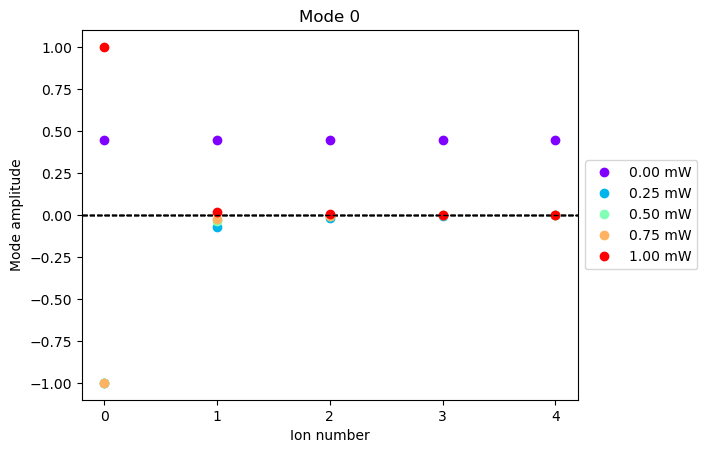

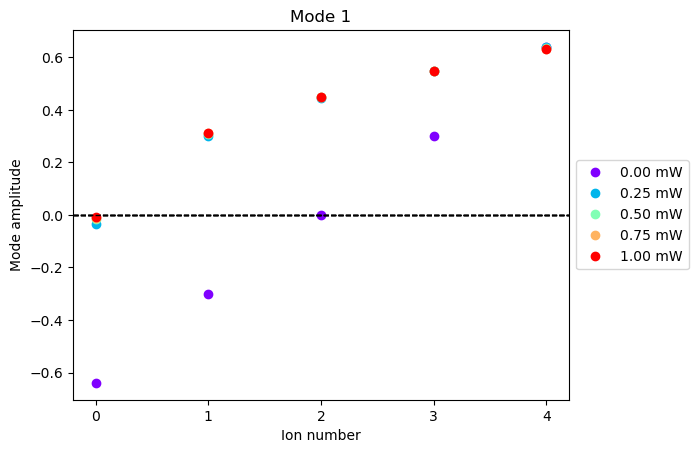

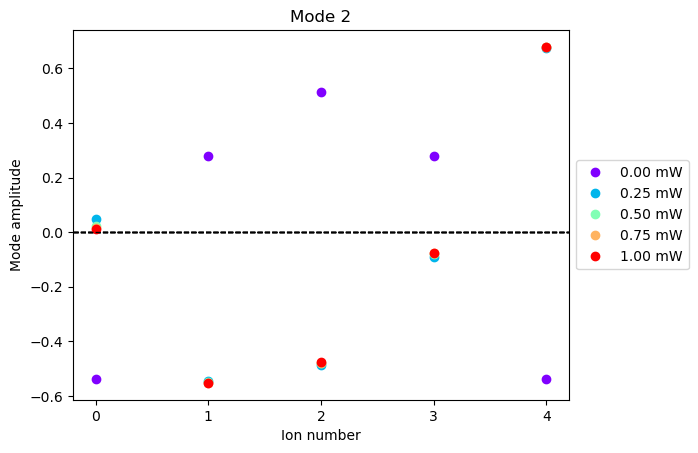

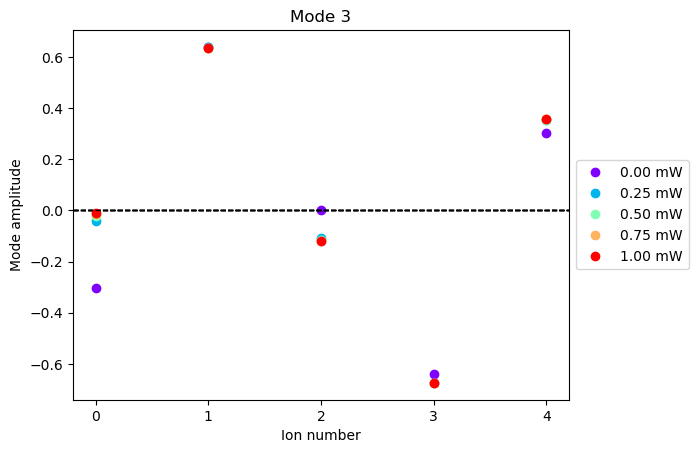

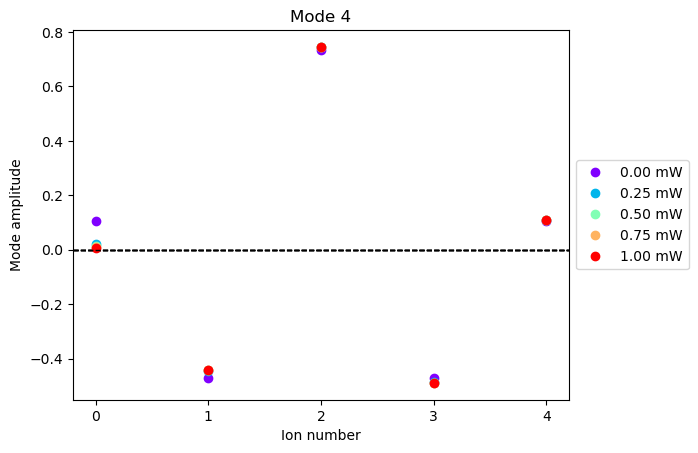

In [ ]:
colors = plt.cm.rainbow(np.linspace(0, 1, len(P_opt)))

for mode_index in range(N):  # Assuming you have two modes to plot (Modes_0[0] and Modes_0[1])
    for i in range(len(P_opt)):
        plt.plot(Modes_0[mode_index][i], 'o', color=colors[i], label=f'{P_opt[i]:.2f} mW')
        plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Add horizontal line at y=0
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside the plot, on the right side
    plt.xlabel('Ion number')
    plt.xticks(range(N))
    plt.ylabel('Mode amplitude')
    plt.title(f'Mode {mode_index}')
    plt.show()



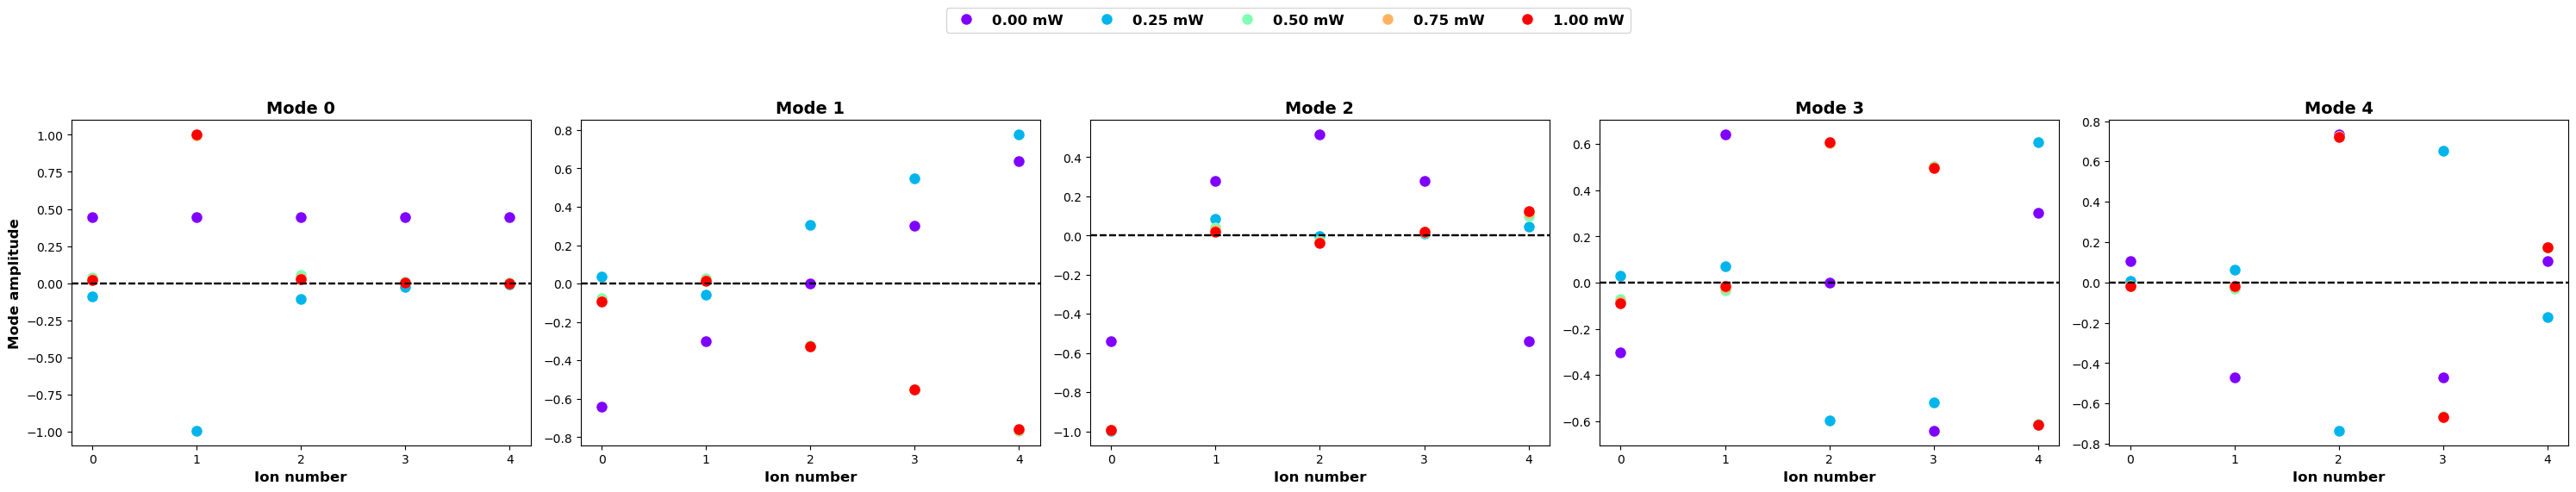

In [ ]:
colors = plt.cm.rainbow(np.linspace(0, 1, len(P_opt)))
fig, axes = plt.subplots(nrows=1, ncols=N, figsize=(6 * N, 5))  # Create a figure with 1 row and N columns

# Store lines and labels for the legend
lines = []
labels = []

for mode_index in range(N):
    ax = axes[mode_index]  # Select the current subplot
    for i in range(len(P_opt)):
        # Only plot markers without lines
        line, = ax.plot(Modes_1[mode_index][i], 'o', color=colors[i], label=f'{P_opt[i]:.2f} mW', markersize=8, linewidth=2)
        if mode_index == 0:  # Collect legend handles and labels only from the first plot
            lines.append(line)
            labels.append(f'{P_opt[i]:.2f} mW')
        ax.axhline(0, color='black', linestyle='--', linewidth=1.5)  # Add horizontal line at y=0
    ax.set_xlabel('Ion number', fontsize=12, fontweight='bold')
    ax.set_xticks(range(len(Modes_1[mode_index][0])))  # Assuming each mode has the same length for ion numbers
    ax.set_title(f'Mode {mode_index}', fontsize=14, fontweight='bold')
    
    # Only set y-label for the leftmost subplot
    if mode_index == 0:
        ax.set_ylabel('Mode amplitude', fontsize=12, fontweight='bold')

# Add a single legend for the entire figure
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(P_opt), prop={'size': 12, 'weight': 'bold'})
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to prevent overlap and leave space for the legend
plt.show()

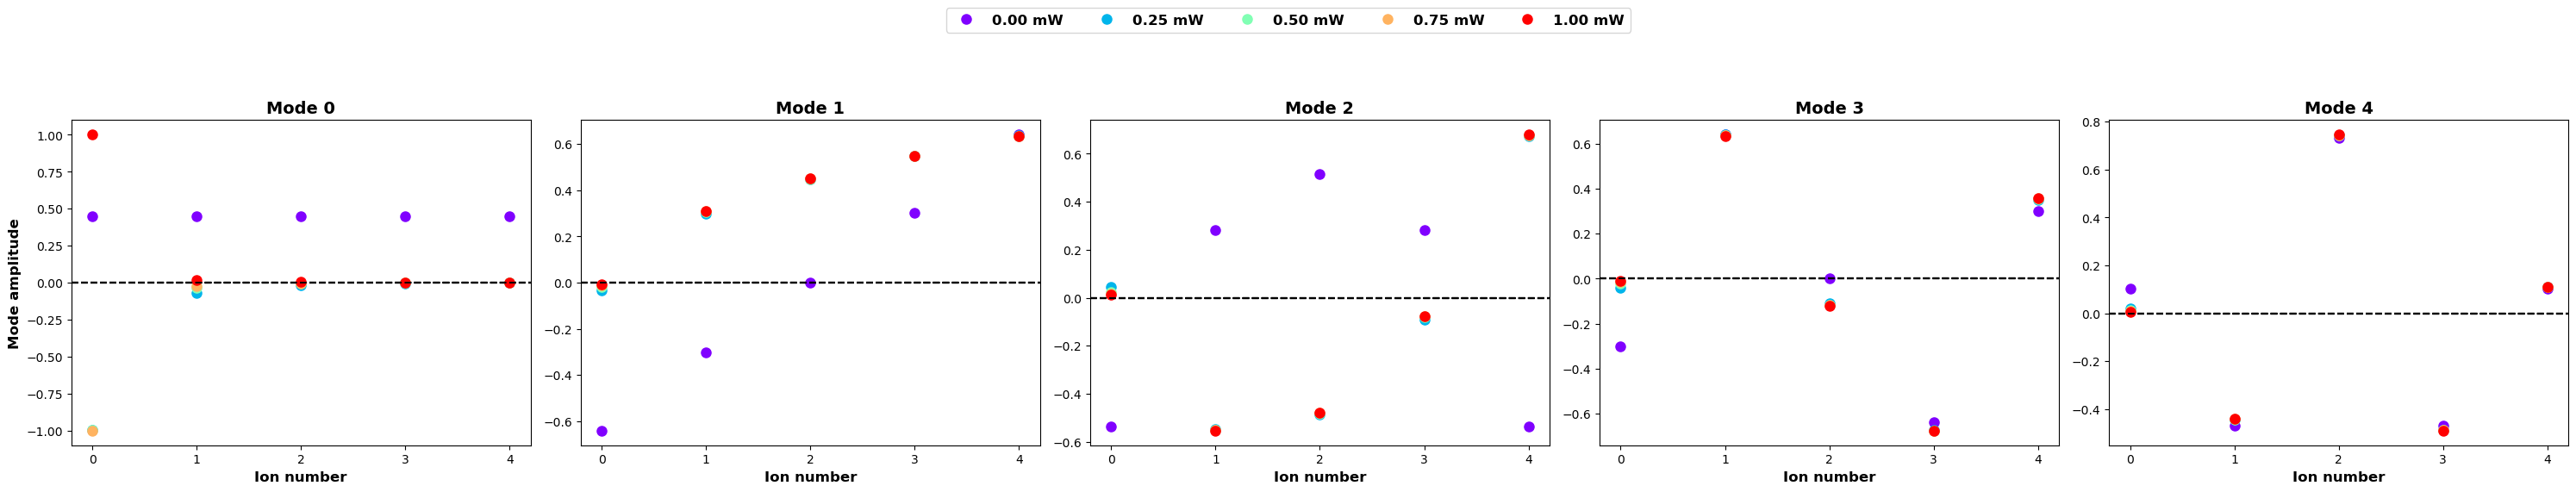

In [ ]:
colors = plt.cm.rainbow(np.linspace(0, 1, len(P_opt)))
fig, axes = plt.subplots(nrows=1, ncols=N, figsize=(6 * N, 5))  # Create a figure with 1 row and N columns

# Store lines and labels for the legend
lines = []
labels = []

for mode_index in range(N):
    ax = axes[mode_index]  # Select the current subplot
    for i in range(len(P_opt)):
        # Only plot markers without lines
        line, = ax.plot(Modes_0[mode_index][i], 'o', color=colors[i], label=f'{P_opt[i]:.2f} mW', markersize=8, linewidth=2)
        if mode_index == 0:  # Collect legend handles and labels only from the first plot
            lines.append(line)
            labels.append(f'{P_opt[i]:.2f} mW')
        ax.axhline(0, color='black', linestyle='--', linewidth=1.5)  # Add horizontal line at y=0
    ax.set_xlabel('Ion number', fontsize=12, fontweight='bold')
    ax.set_xticks(range(len(Modes_1[mode_index][0])))  # Assuming each mode has the same length for ion numbers
    ax.set_title(f'Mode {mode_index}', fontsize=14, fontweight='bold')
    
    # Only set y-label for the leftmost subplot
    if mode_index == 0:
        ax.set_ylabel('Mode amplitude', fontsize=12, fontweight='bold')

# Add a single legend for the entire figure
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(P_opt), prop={'size': 12, 'weight': 'bold'})
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to prevent overlap and leave space for the legend
plt.show()

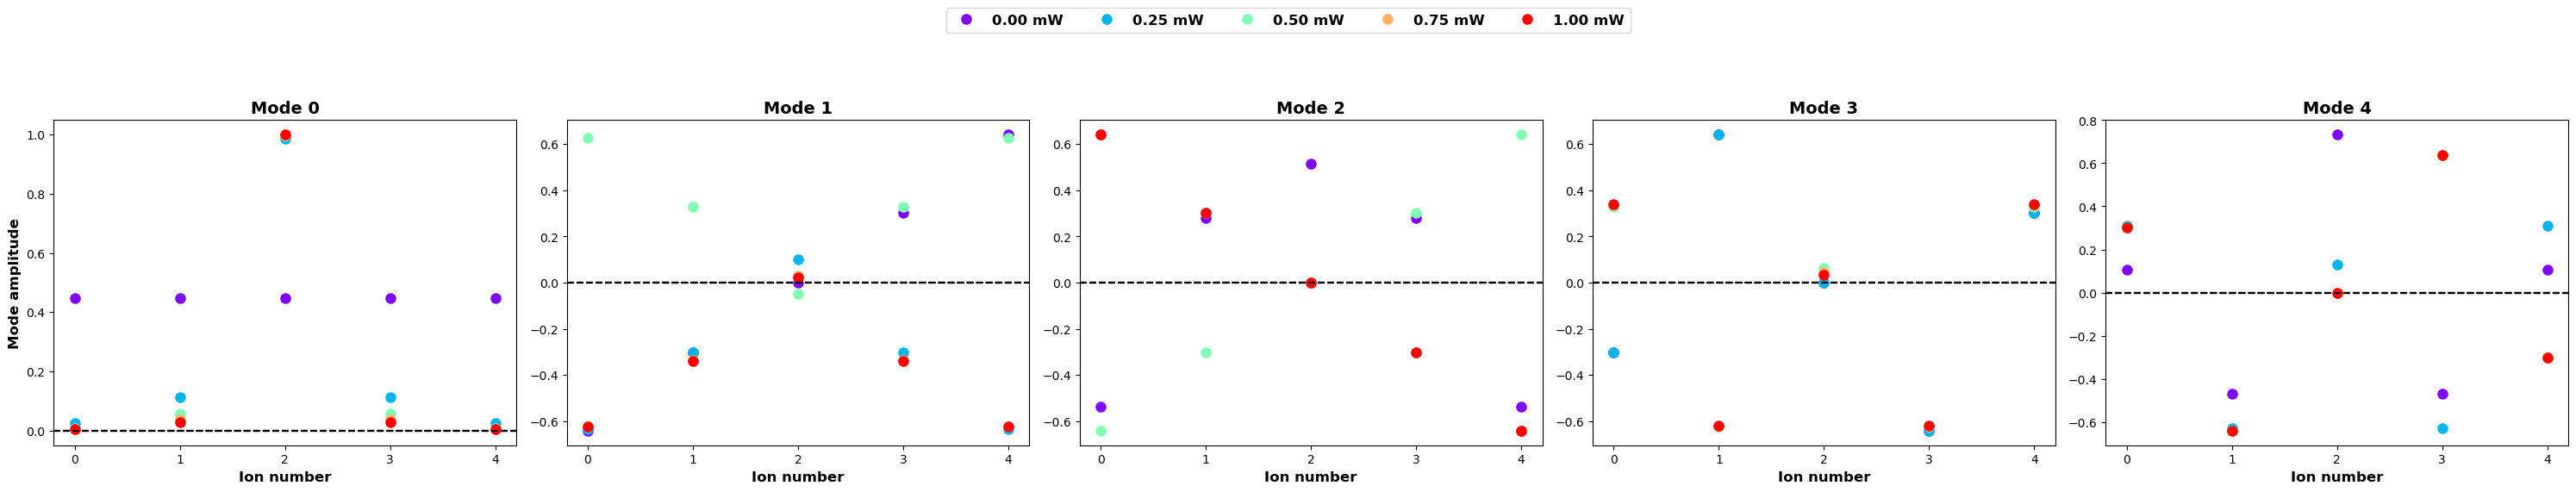

In [ ]:
colors = plt.cm.rainbow(np.linspace(0, 1, len(P_opt)))
fig, axes = plt.subplots(nrows=1, ncols=N, figsize=(6 * N, 5))  # Create a figure with 1 row and N columns

# Store lines and labels for the legend
lines = []
labels = []

for mode_index in range(N):
    ax = axes[mode_index]  # Select the current subplot
    for i in range(len(P_opt)):
        # Only plot markers without lines
        line, = ax.plot(Modes_2[mode_index][i], 'o', color=colors[i], label=f'{P_opt[i]:.2f} mW', markersize=8, linewidth=2)
        if mode_index == 0:  # Collect legend handles and labels only from the first plot
            lines.append(line)
            labels.append(f'{P_opt[i]:.2f} mW')
        ax.axhline(0, color='black', linestyle='--', linewidth=1.5)  # Add horizontal line at y=0
    ax.set_xlabel('Ion number', fontsize=12, fontweight='bold')
    ax.set_xticks(range(len(Modes_1[mode_index][0])))  # Assuming each mode has the same length for ion numbers
    ax.set_title(f'Mode {mode_index}', fontsize=14, fontweight='bold')
    
    # Only set y-label for the leftmost subplot
    if mode_index == 0:
        ax.set_ylabel('Mode amplitude', fontsize=12, fontweight='bold')

# Add a single legend for the entire figure
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(P_opt), prop={'size': 12, 'weight': 'bold'})
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to prevent overlap and leave space for the legend
plt.show()

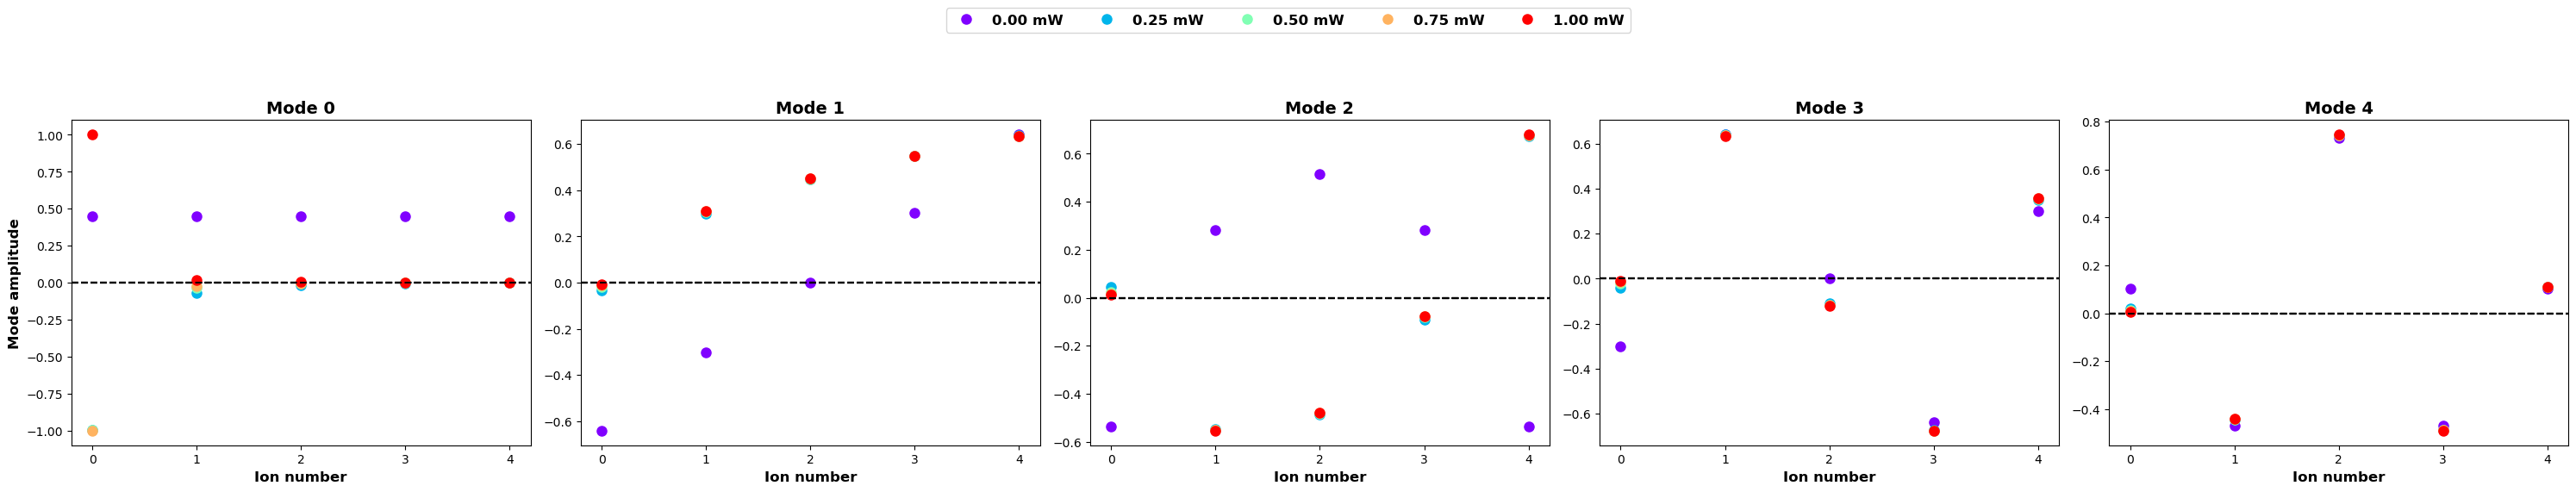

In [ ]:
colors = plt.cm.rainbow(np.linspace(0, 1, len(P_opt)))
fig, axes = plt.subplots(nrows=1, ncols=N, figsize=(6 * N, 5))  # Create a figure with 1 row and N columns

# Store lines and labels for the legend
lines = []
labels = []

for mode_index in range(N):
    ax = axes[mode_index]  # Select the current subplot
    for i in range(len(P_opt)):
        # Only plot markers without lines
        line, = ax.plot(Modes_0[mode_index][i], 'o', color=colors[i], label=f'{P_opt[i]:.2f} mW', markersize=8, linewidth=2)
        if mode_index == 0:  # Collect legend handles and labels only from the first plot
            lines.append(line)
            labels.append(f'{P_opt[i]:.2f} mW')
        ax.axhline(0, color='black', linestyle='--', linewidth=1.5)  # Add horizontal line at y=0
    ax.set_xlabel('Ion number', fontsize=12, fontweight='bold')
    ax.set_xticks(range(len(Modes_1[mode_index][0])))  # Assuming each mode has the same length for ion numbers
    ax.set_title(f'Mode {mode_index}', fontsize=14, fontweight='bold')
    
    # Only set y-label for the leftmost subplot
    if mode_index == 0:
        ax.set_ylabel('Mode amplitude', fontsize=12, fontweight='bold')

# Add a single legend for the entire figure
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(P_opt), prop={'size': 12, 'weight': 'bold'})
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to prevent overlap and leave space for the legend
plt.show()

In [ ]:
def combined_frequencies(N,tweezed_ions,w_tweezer_r,w_tweezer_a,w_rf_r,w_rf_a):
    '''
    takes in rf and tweezer trap frequencies and adds together frequencies in quadruture
    radial modes will be effected by either the radial and axial tweezer directions (in BladeRunner setup)
    axial modes will be effected by only tweezer radial
    
    inputs:
    N = number of ions
    tweezed_ions = list of which ions are getting tweezed
    w_tweezer_r = radial trapping frequency of tweezer [2*Pi x Hz]
    w_tweezer_a = axial trapping frequency of tweezer [2*Pi x Hz]
    w_rf_r = radial rf trapping frequency [2*Pi x Hz]
    w_rf_a = axial rf trapping frequency [2*Pi x Hz]
    
    returns: array of potential combined trapping frequencies
                [0] is radial rf and radial tweezer
                [1] is radial rf and axial tweezer
                [2] is axial rf and radial tweezer
    
    '''

    omeg_tweezer_r = np.zeros(N)
    omeg_tweezer_a = np.zeros(N)
    omeg_tweezer_r[tweezed_ions] = w_tweezer_r
    omeg_tweezer_a[tweezed_ions] = w_tweezer_a

    omeg_rf_r = w_rf_r * np.ones(N) 
    omeg_rf_a = w_rf_a * np.ones(N)

    omega_combined_rr = np.sqrt(omeg_rf_r**2 + omeg_tweezer_r**2)
    omega_combined_ra = np.sqrt(omeg_rf_r**2 + omeg_tweezer_a)
    omega_combined_ar = np.sqrt(omeg_rf_a**2 + omeg_tweezer_r**2)
    
    return np.array([omega_combined_rr,omega_combined_ra,omega_combined_ar])

In [ ]:
tweezed_ions = [0]
N = 5
tweezer_wavelength = 532e-9
P_opt = 5e-3
w_tweezer_r = tweezer_optical_potential_to_trap_frequency(tweezer_wavelength,linewidths,omega_res,P_opt,beam_waist,m)[0]
w_tweezer_a = tweezer_optical_potential_to_trap_frequency(tweezer_wavelength,linewidths,omega_res,P_opt,beam_waist,m)[1]
combined_frequencies(N,tweezed_ions,w_tweezer_r,w_tweezer_a,w_rf_r,w_rf_a)[0]

array([6299184.51859767, 6283185.30717959, 6283185.30717959,
       6283185.30717959, 6283185.30717959])